# Label Clusters

Based on the centeroid of each label, we will try to find label clusters.

In [2]:
from mediaeval2021.dataloaders import acousticbrainz
import pandas as pd

dataset_path = '../data/mediaeval2019/'

dataloader = acousticbrainz.AcousticBrainzLoader(
    training_path=dataset_path + 'accousticbrainz-train.pickle',
    test_path=dataset_path + 'accousticbrainz-test.pickle',
    validation_path=dataset_path + 'accousticbrainz-validation.pickle',
)

train_data = dataloader.load_train()

features = dataloader.columns[2:]
train_features = pd.DataFrame(train_data[0], columns=features)

labels = list(map(lambda c: c[13:], dataloader.mlb.classes_))
train_labels = pd.DataFrame(train_data[1], columns=labels)


train_data = train_features.merge(train_labels, left_index=True, right_index=True)

centeroids = {}
for label in labels:
    centeroids[label] = train_data.loc[train_data[label] == 1][features].mean()

representative_samples = pd.DataFrame(centeroids).T

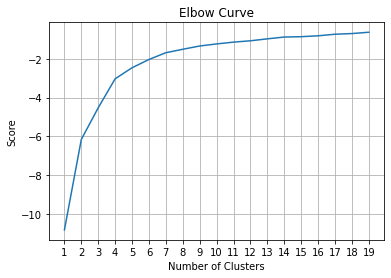

In [3]:
from sklearn import cluster
import matplotlib.pyplot as plt

Nc = range(1, 20)
kmeans = [cluster.KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(representative_samples).score(representative_samples) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xticks(Nc)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.grid(True)
plt.show()

In [4]:
clustering = pd.DataFrame(representative_samples.index, columns=['label'])


n_clusters = 8

clustering['k-means_cluster'] = cluster.KMeans(n_clusters=n_clusters, random_state=0).fit(representative_samples).labels_
clustering['spectral_cluster'] = cluster.SpectralClustering(n_clusters=n_clusters).fit(representative_samples).labels_
clustering['agglomerative_cluster'] = cluster.AgglomerativeClustering(n_clusters=n_clusters).fit(representative_samples).labels_

display(clustering)

,label,k-means_cluster,spectral_cluster,agglomerative_cluster
0,action,2,4,0
1,adventure,1,0,0
2,advertising,1,0,2
3,background,1,0,2
4,ballad,6,7,3
5,calm,1,0,0
6,children,6,7,3
7,christmas,6,7,3
8,commercial,4,2,6
9,cool,2,0,0


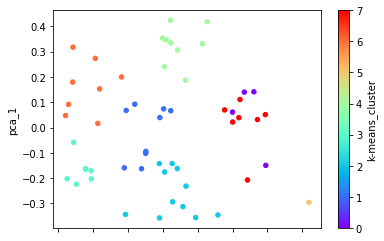

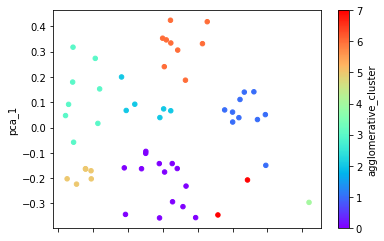

In [5]:
from sklearn.decomposition import PCA

pc = PCA(n_components=2).fit_transform(representative_samples)
clustering['pca_0'] = pc[... ,0]
clustering['pca_1'] = pc[..., 1]

clustering.plot.scatter(x='pca_0', y='pca_1', c='k-means_cluster', colormap='rainbow')
plt.show()
clustering.plot.scatter(x='pca_0', y='pca_1', c='agglomerative_cluster', colormap='rainbow')
plt.show()

In [6]:
### DIKmeans

import numpy as np
import math 
import random

def find_centroid(pt1, pt2):
    return (pt1 + pt2) / 2

def get_max_distance_label(pt, df_samples, labels):
    max_dis = -1
    max_dis_label = ''
    for idx, sample in df_samples.iterrows():
        if np.linalg.norm(pt - sample.to_numpy()) > max_dis and idx in labels:
            max_dis = np.linalg.norm(pt - sample.to_numpy())
            max_dis_label = idx

    return max_dis_label

#amount_categories = 56
n_models = 10
#cats_per_model = math.ceil(amount_categories / n_models)

labels = representative_samples.index.to_list()
label_assignment = {}
# init phase
for i in range(n_models):
    label = random.choice(labels)
    max_distance_label = get_max_distance_label(representative_samples.loc[label], representative_samples, labels)
    label_assignment[i] = [label, max_distance_label]
    labels.remove(label)
    labels.remove(max_distance_label)

# iteration  
while len(labels) > 0:
    for i in range(n_models):
        label1 = label_assignment[i][-1]
        label2 = label_assignment[i][-2]
        centroid = find_centroid(representative_samples.loc[label1], representative_samples.loc[label2])
        max_distance_label = get_max_distance_label(centroid, representative_samples, labels)
        label_assignment[i].append(max_distance_label)
        labels.remove(max_distance_label)

        if len(labels) == 0:
            break

print(label_assignment)


{0: ['children', 'heavy', 'nature', 'corporate', 'cool', 'adventure'], 1: ['meditative', 'party', 'positive', 'emotional', 'trailer', 'motivational'], 2: ['drama', 'sexy', 'energetic', 'romantic', 'calm', 'melodic'], 3: ['sad', 'powerful', 'hopeful', 'film', 'uplifting', 'travel'], 4: ['groovy', 'holiday', 'dark', 'fun', 'background', 'dream'], 5: ['funny', 'soft', 'retro', 'action', 'happy', 'advertising'], 6: ['soundscape', 'upbeat', 'melancholic', 'movie', 'game'], 7: ['space', 'christmas', 'summer', 'epic', 'love'], 8: ['ballad', 'deep', 'fast', 'inspiring', 'slow'], 9: ['documentary', 'sport', 'relaxing', 'commercial', 'dramatic']}
